In [ ]:
using LinearAlgebra, Random, Distributions, PyPlot

## Linear case

In [2]:
Ac1 = [0.99 0.0; 0.0 0.1]
Ac2 = [0.65 0.5; 0.5 0.2]
Ae1 = [1.05 0.01; 0.01 1]
Ae2 = [cos(0.1π) -sin(0.1π); sin(0.1π) cos(0.1π)]
Acs = vcat(hcat(Ac1, zeros(2,2)), hcat(zeros(2,2), Ac2))
Aes = vcat(hcat(Ae1, zeros(2,2)), hcat(zeros(2,2), Ae2));

In [4]:
opnorm(Ac1), opnorm(Ac2), opnorm(Ae1), opnorm(Ae2), opnorm(Acs), opnorm(Aes)

(0.99, 0.9732928049865328, 1.0519258240356724, 1.0, 0.99, 1.0519258240356726)

In [5]:
T = 1000;
Q = 0.01 * diagm(ones(2))
R = 0.0001 * diagm(ones(2))
H = diagm([1,1])
Qs = 0.01 * diagm(ones(4))
Rs = 0.0001 * diagm(ones(2))
Hs = hcat(H, H);

In [6]:
function generate_signal(nr_samples, A, H, Q, R)
    x_true = randn(nr_samples, 2)
    y_true = randn(nr_samples, 2)
    y_true[1,:] = rand(MvNormal(H*x_true[1,:], R))
    for k in 2:nr_samples
        x_true[k,:] = rand(MvNormal(A*x_true[k-1,:], Q))
        y_true[k,:] = rand(MvNormal(H*x_true[k,:], R))
    end
    return y_true, x_true
end;

In [7]:
y_c1, x_c1 = generate_signal(T, [0.99 0.0; 0.0 0.3], H, Q, R)
# y_c1, x_c1 = generate_signal(T, Ac1, H, Q, R)
y_c2, x_c2 = generate_signal(T, Ac2, H, Q, R)
y_e1, x_e1 = generate_signal(T, [1.04 0.01; 0.01 1], H, Q, R)
# y_e1, x_e1 = generate_signal(T, Ae1, H, Q, R)
y_e2, x_e2 = generate_signal(T, Ae2, H, Q, R)

y_c = y_c1 + y_c2
y_e = y_e1 + y_e2;

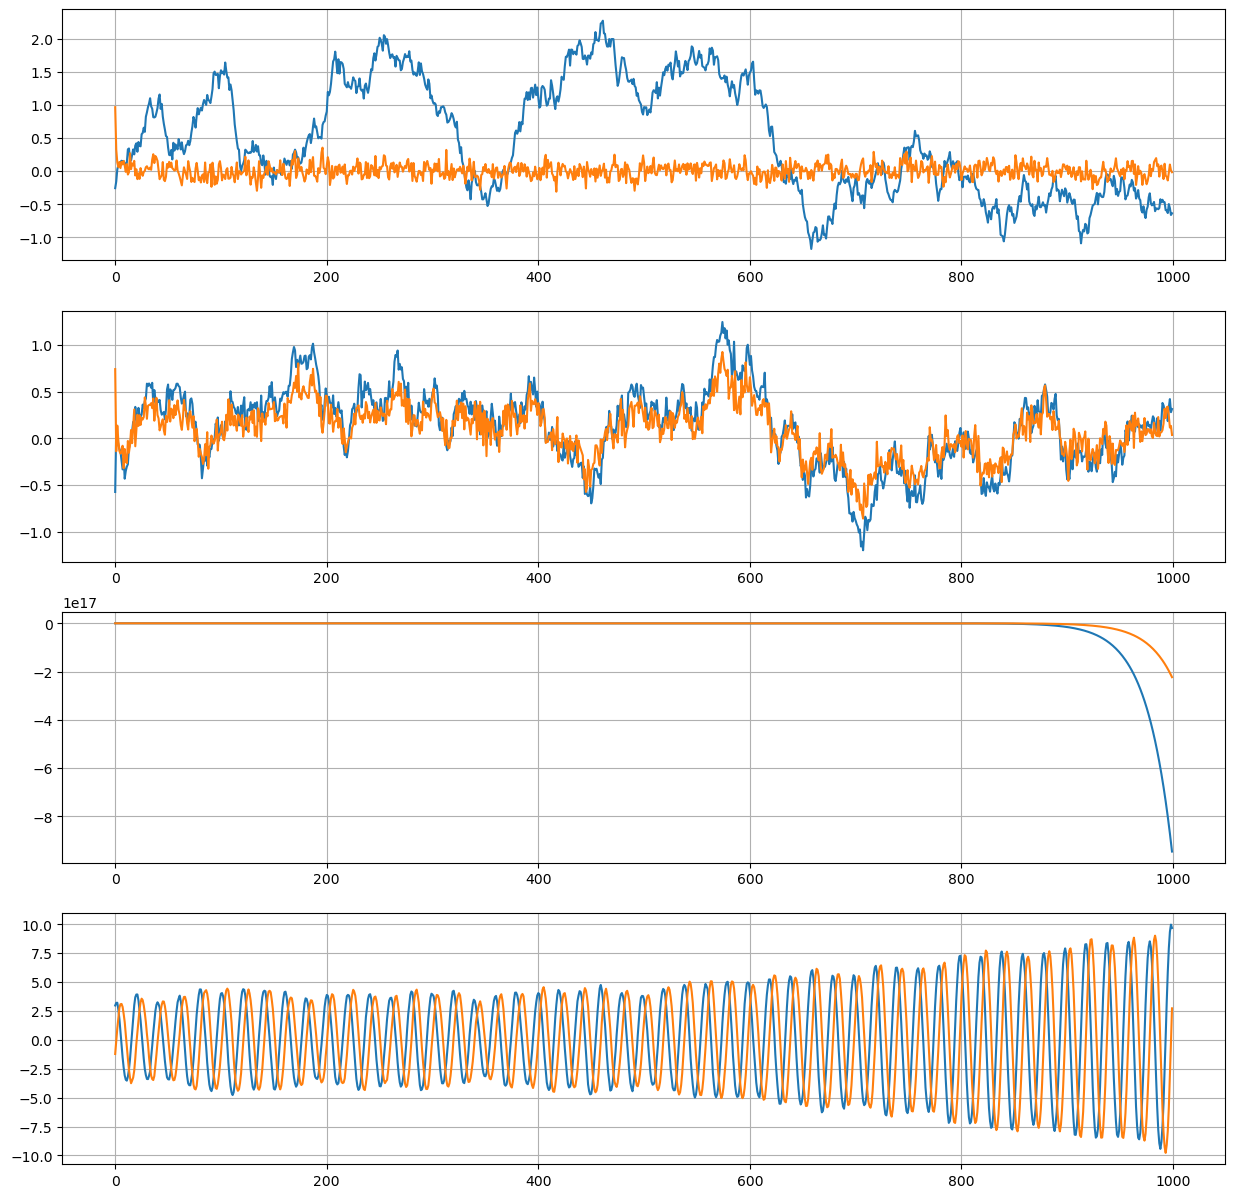

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\s151781\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


In [8]:
_, ax = plt.subplots(nrows=4, figsize=(15,15))
ax[1].plot(y_c1)
ax[2].plot(y_c2)
ax[3].plot(y_e1)
ax[4].plot(y_e2)
ax[1].grid(), ax[2].grid(), ax[3].grid(), ax[4].grid();

In [9]:
function KF(signal, A, H, Q, R)

    # memory
    mem_x_m = Vector{Vector{Float64}}(undef, size(signal,1))
    mem_x_v = Vector{Matrix{Float64}}(undef, size(signal,1))

    # priors
    m_x = zeros(4)
    V_x = 5*diagm(ones(4))

    for k in 1:size(signal,1)
        
        # predict step
        m_x_new = A * m_x
        V_x_new = A*V_x*A' + Q

        # update step
        y = signal[k,:] - H*m_x_new
        S = H*V_x_new*H' + R
        K = V_x_new * H' * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H)*V_x_new

        # save values
        mem_x_m[k] = copy(m_x)
        mem_x_v[k] = copy(V_x)

    end

    return mem_x_m, mem_x_v

end

KF (generic function with 1 method)

In [10]:
xmc_sep, xvc_sep = KF(y_c, Acs, Hs, Qs, Rs);
xme_sep, xve_sep = KF(y_e, Aes, Hs, Qs, Rs);

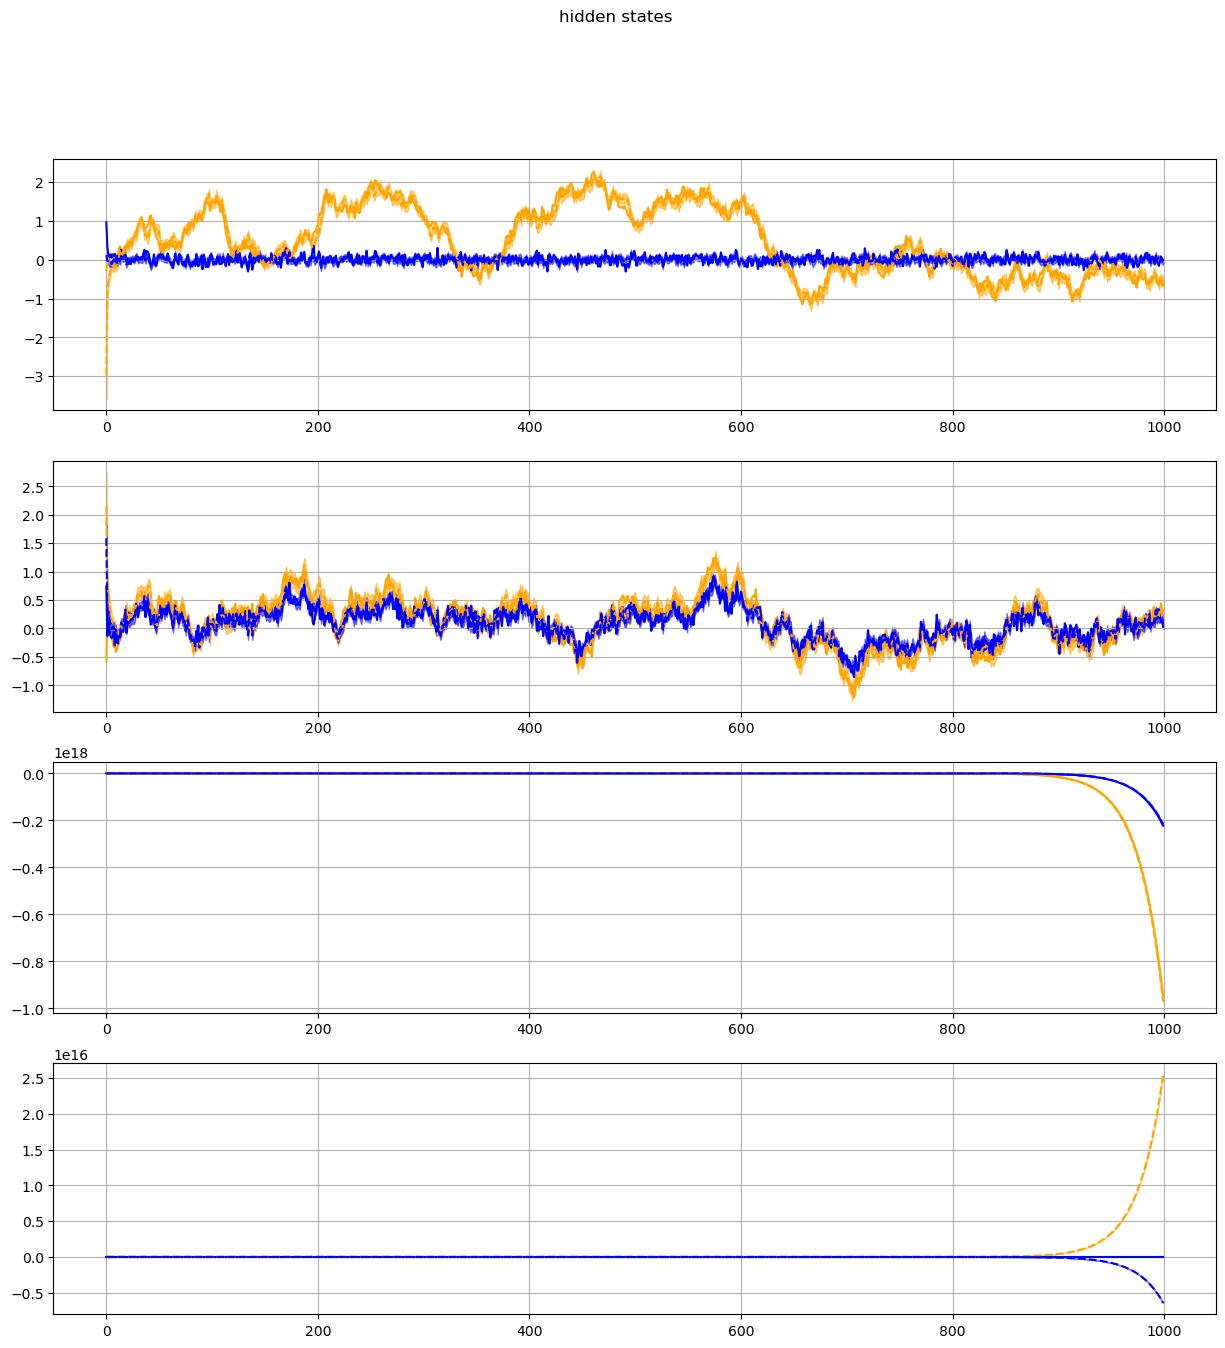

In [11]:
xmc_sepp = hcat(xmc_sep...)'
xvc_sepp = reshape(reduce(hcat, xvc_sep), 4,4,:)
xme_sepp = hcat(xme_sep...)'
xve_sepp = reshape(reduce(hcat, xve_sep), 4,4,:)

fig, ax = plt.subplots(nrows=4, figsize=(15,15))
ax[1].plot(x_c1[:,1], color="orange")
ax[1].plot(x_c1[:,2], color="blue")
ax[1].plot(xmc_sepp[:,1], color="orange", linestyle="--")
ax[1].plot(xmc_sepp[:,2], color="blue", linestyle="--")
ax[1].fill_between(0:T-1, xmc_sepp[:,1] .+ sqrt.(xvc_sepp[1,1,:]), xmc_sepp[:,1] .- sqrt.(xvc_sepp[1,1,:]), color="orange", alpha=0.5)
ax[1].fill_between(0:T-1, xmc_sepp[:,2] .+ sqrt.(xvc_sepp[2,2,:]), xmc_sepp[:,2] .- sqrt.(xvc_sepp[2,2,:]), color="blue", alpha=0.5)

ax[2].plot(x_c2[:,1], color="orange")
ax[2].plot(x_c2[:,2], color="blue")
ax[2].plot(xmc_sepp[:,3], color="orange", linestyle="--")
ax[2].plot(xmc_sepp[:,4], color="blue", linestyle="--")
ax[2].fill_between(0:T-1, xmc_sepp[:,3] .+ sqrt.(xvc_sepp[3,3,:]), xmc_sepp[:,3] .- sqrt.(xvc_sepp[3,3,:]), color="orange", alpha=0.5)
ax[2].fill_between(0:T-1, xmc_sepp[:,4] .+ sqrt.(xvc_sepp[4,4,:]), xmc_sepp[:,4] .- sqrt.(xvc_sepp[4,4,:]), color="blue", alpha=0.5)

ax[3].plot(x_e1[:,1], color="orange")
ax[3].plot(x_e1[:,2], color="blue")
ax[3].plot(xme_sepp[:,1], color="orange", linestyle="--")
ax[3].plot(xme_sepp[:,2], color="blue", linestyle="--")
ax[3].fill_between(0:T-1, xme_sepp[:,1] .+ sqrt.(xve_sepp[1,1,:]), xme_sepp[:,1] .- sqrt.(xve_sepp[1,1,:]), color="orange", alpha=0.5)
ax[3].fill_between(0:T-1, xme_sepp[:,2] .+ sqrt.(xve_sepp[2,2,:]), xme_sepp[:,2] .- sqrt.(xve_sepp[2,2,:]), color="blue", alpha=0.5)

ax[4].plot(x_e2[:,1], color="orange")
ax[4].plot(x_e2[:,2], color="blue")
ax[4].plot(xme_sepp[:,3], color="orange", linestyle="--")
ax[4].plot(xme_sepp[:,4], color="blue", linestyle="--")
ax[4].fill_between(0:T-1, xme_sepp[:,3] .+ sqrt.(xve_sepp[3,3,:]), xme_sepp[:,3] .- sqrt.(xve_sepp[3,3,:]), color="orange", alpha=0.5)
ax[4].fill_between(0:T-1, xme_sepp[:,4] .+ sqrt.(xve_sepp[4,4,:]), xme_sepp[:,4] .- sqrt.(xve_sepp[4,4,:]), color="blue", alpha=0.5)

fig.suptitle("hidden states")
ax[1].grid(), ax[2].grid(), ax[3].grid(), ax[4].grid();

It seems that a mismatch in the state dynamics model leads to bad source separation estimates. In particularly by expansive funcitons, this behaviour leads to divergence.

## Nonlinear case

In [12]:
fc1(x) = sqrt(x^2 + 5)
dfc1(x) = x / sqrt(x^2 + 5)
fc2(x) = log(x^2 + 6)
dfc2(x) = 2 * x / (x^2 + 6)
fe1(x) = sign(x-1)*abs(x-1)^1.0001
dfe1(x) = 1.001*sign(x-1)*abs(x-1)^0.0001
fe2(x) =  sign(x-2)*abs(x-2)^1.0005
dfe2(x) = 1.0005*sign(x-2)*abs(x-2)^0.0005

fsc(x) = [fc1(x[1]), fc2(x[2])]
dfsc(x) = [dfc1(x[1]) 0; 0 dfc2(x[2])]
fse(x) = [fe1(x[1]), fe2(x[2])]
dfse(x) = [dfe1(x[1]) 0; 0 dfe2(x[2])];

In [13]:
T = 1000
Q = 0.01
R = 0.0001
H = 1
Qs = 0.01 * diagm(ones(2))
Rs = 0.0001 
Hs = [1, 1];

In [14]:
function generate_signal(nr_samples, f, H, Q, R)
    x_true = randn(nr_samples)
    y_true = randn(nr_samples)
    y_true[1] = rand(Normal(H*x_true[1], R))
    for k in 2:nr_samples
        x_true[k] = rand(Normal(f(x_true[k-1]), Q))
        y_true[k] = rand(Normal(H*x_true[k], R))
    end
    return y_true, x_true
end;

In [15]:
y_c1, x_c1 = generate_signal(T, fc1, H, Q, R)
y_c2, x_c2 = generate_signal(T, fc2, H, Q, R)
y_e1, x_e1 = generate_signal(T, fe1, H, Q, R)
y_e2, x_e2 = generate_signal(T, fe2, H, Q, R)

y_c = y_c1 + y_c2
y_e = y_e1 + y_e2;

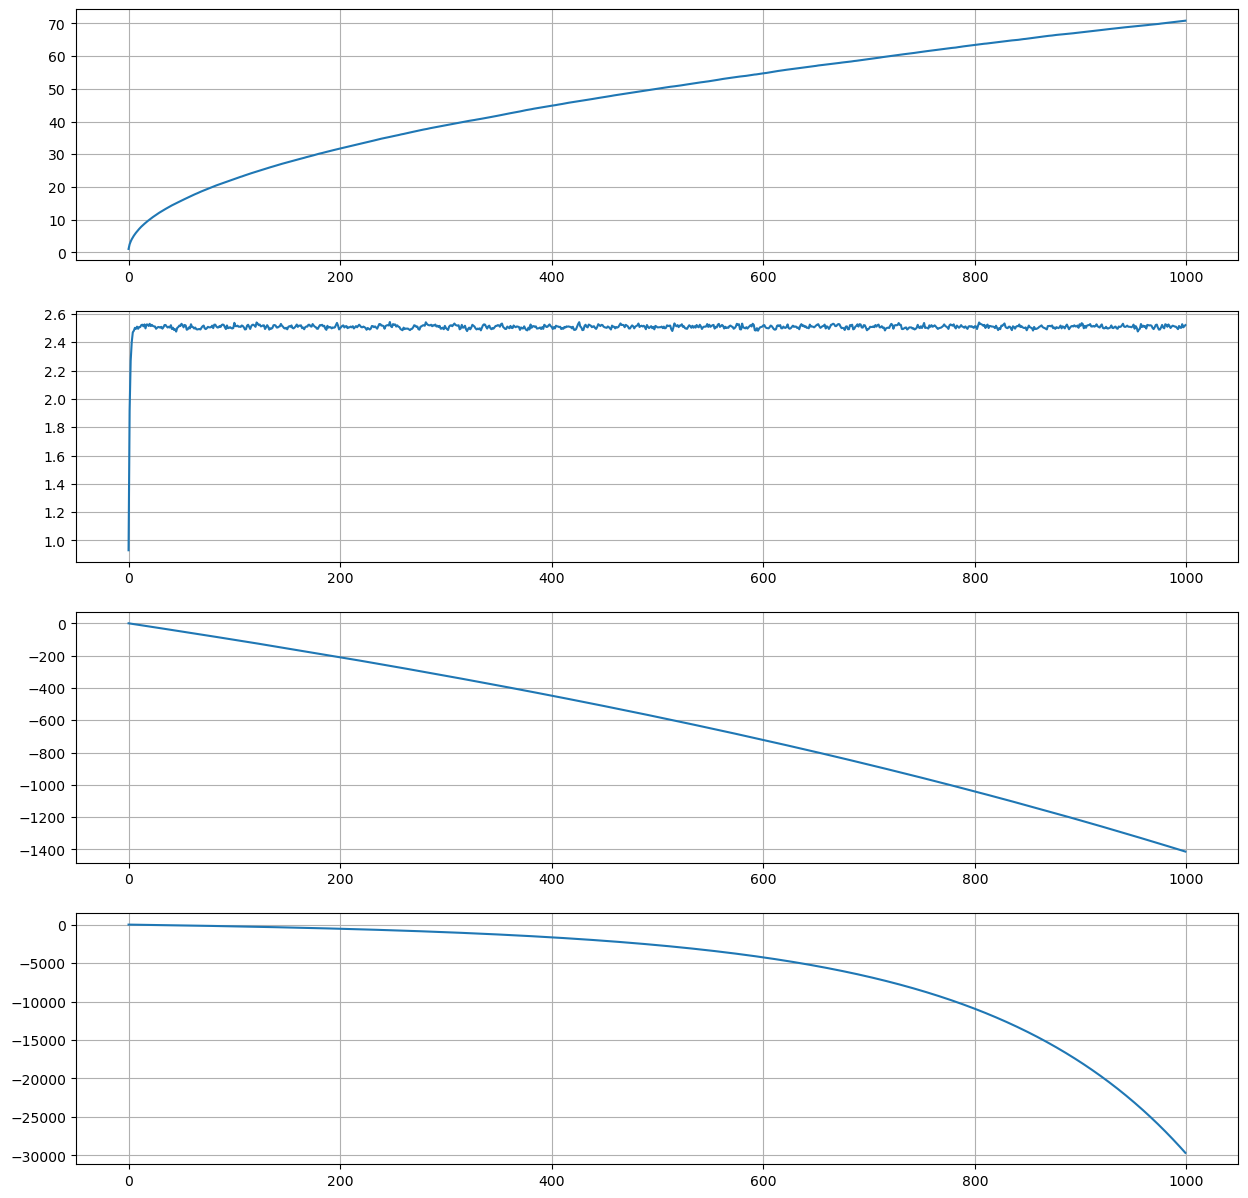

In [16]:
_, ax = plt.subplots(nrows=4, figsize=(15,15))
ax[1].plot(y_c1)
ax[2].plot(y_c2)
ax[3].plot(y_e1)
ax[4].plot(y_e2)
ax[1].grid(), ax[2].grid(), ax[3].grid(), ax[4].grid();

In [17]:
function EKF(signal, f, df, H, Q, R)

    # memory
    mem_x_m = Vector{Vector{Float64}}(undef, length(signal))
    mem_x_v = Vector{Matrix{Float64}}(undef, length(signal))

    # priors
    m_x = zeros(2)
    V_x = 5*diagm(ones(2))

    for k in 1:length(signal)
        
        # predict step
        m_x_new = f(m_x)
        J = df(m_x)
        V_x_new = J*V_x*J' + Q

        # update step
        y = signal[k] - dot(H,m_x_new)
        S = dot(H, V_x_new, H) + R
        K = V_x_new * H * inv(S)
        m_x = m_x_new + K*y
        # V_x = V_x_new - K*S*K'
        V_x = (I - K*H')*V_x_new

        # save values
        mem_x_m[k] = copy(m_x)
        mem_x_v[k] = copy(V_x)

    end

    return mem_x_m, mem_x_v

end

EKF (generic function with 1 method)

In [18]:
# add slight offsets

# fc1(x) = sqrt(x^2 + 5)
# dfc1(x) = x / sqrt(x^2 + 5)
# fc2(x) = log(x^2 + 6)
# dfc2(x) = 2 * x / (x^2 + 6)
# fe1(x) = sign(x-1)*abs(x-1)^1.0001
# dfe1(x) = 1.001*sign(x-1)*abs(x-1)^0.0001
# fe2(x) =  sign(x-2)*abs(x-2)^1.0005
# dfe2(x) = 1.0005*sign(x-2)*abs(x-2)^0.0005
fc1(x) = sqrt(x^2 + 5.5)
dfc1(x) = x / sqrt(x^2 + 5.5)
fc2(x) = log(x^2 + 6.2)
dfc2(x) = 2 * x / (x^2 + 6.2)
fe1(x) = sign(x-1.5)*abs(x-1.5)^1.0001
dfe1(x) = 1.001*sign(x-1.5)*abs(x-1.5)^0.0001
fe2(x) =  sign(x-2.2)*abs(x-2.2)^1.0005
dfe2(x) = 1.0005*sign(x-2.2)*abs(x-2.2)^0.0005

dfe2 (generic function with 1 method)

In [19]:
xmc_sep, xvc_sep = EKF(y_c, fsc, dfsc, Hs, Qs, Rs);
xme_sep, xve_sep = EKF(y_e, fse, dfse, Hs, Qs, Rs);

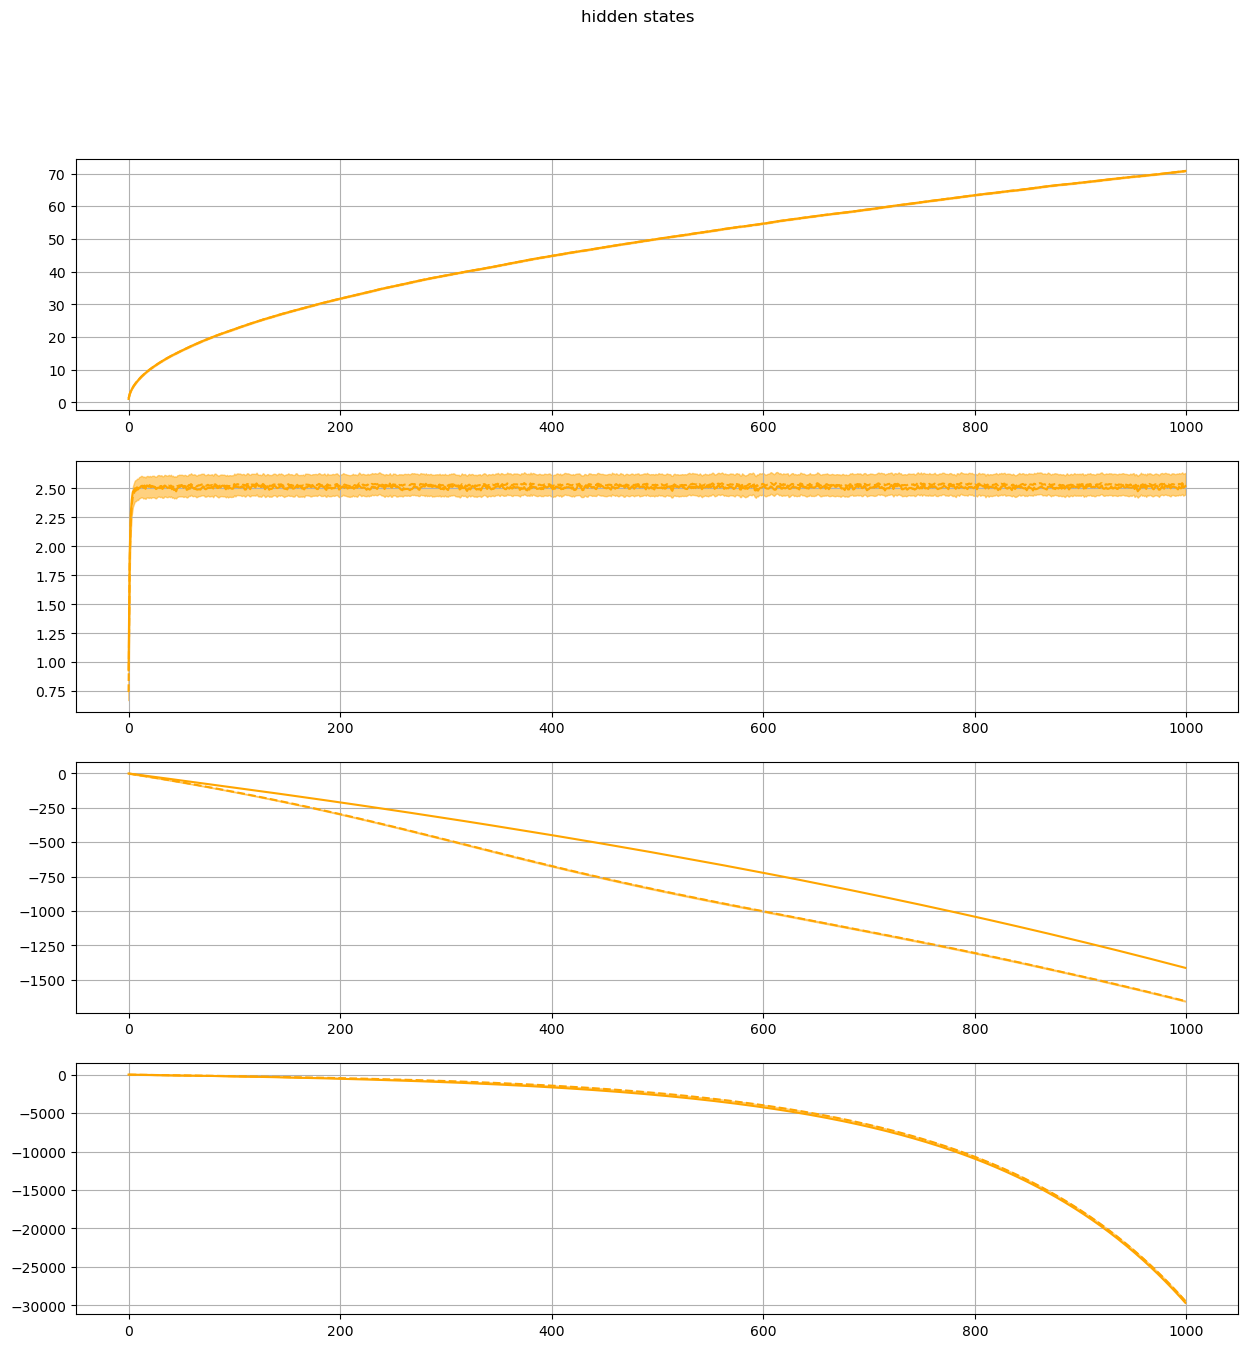

In [20]:
xmc_sepp = hcat(xmc_sep...)'
xvc_sepp = reshape(reduce(hcat, xvc_sep), 2,2,:)
xme_sepp = hcat(xme_sep...)'
xve_sepp = reshape(reduce(hcat, xve_sep), 2,2,:)

fig, ax = plt.subplots(nrows=4, figsize=(15,15))
ax[1].plot(x_c1, color="orange")
ax[1].plot(xmc_sepp[:,1], color="orange", linestyle="--")
ax[1].fill_between(0:T-1, xmc_sepp[:,1] .+ sqrt.(xvc_sepp[1,1,:]), xmc_sepp[:,1] .- sqrt.(xvc_sepp[1,1,:]), color="orange", alpha=0.5)

ax[2].plot(x_c2, color="orange")
ax[2].plot(xmc_sepp[:,2], color="orange", linestyle="--")
ax[2].fill_between(0:T-1, xmc_sepp[:,2] .+ sqrt.(xvc_sepp[2,2,:]), xmc_sepp[:,2] .- sqrt.(xvc_sepp[2,2,:]), color="orange", alpha=0.5)

ax[3].plot(x_e1, color="orange")
ax[3].plot(xme_sepp[:,1], color="orange", linestyle="--")
ax[3].fill_between(0:T-1, xme_sepp[:,1] .+ sqrt.(xve_sepp[1,1,:]), xme_sepp[:,1] .- sqrt.(xve_sepp[1,1,:]), color="orange", alpha=0.5)

ax[4].plot(x_e2, color="orange")
ax[4].plot(xme_sepp[:,2], color="orange", linestyle="--")
ax[4].fill_between(0:T-1, xme_sepp[:,2] .+ sqrt.(xve_sepp[2,2,:]), xme_sepp[:,2] .- sqrt.(xve_sepp[2,2,:]), color="orange", alpha=0.5)

fig.suptitle("hidden states")
ax[1].grid(), ax[2].grid(), ax[3].grid(), ax[4].grid();